# Import  library

In [1]:
import numpy as np
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/classification-of-plants-of-southeast-asia/sample_submission.csv
/kaggle/input/classification-of-plants-of-southeast-asia/bali-26_train/bali-26_train/passiflora/26556.jpg
/kaggle/input/classification-of-plants-of-southeast-asia/bali-26_train/bali-26_train/passiflora/26645.jpg
/kaggle/input/classification-of-plants-of-southeast-asia/bali-26_train/bali-26_train/passiflora/26076.jpg
/kaggle/input/classification-of-plants-of-southeast-asia/bali-26_train/bali-26_train/passiflora/26072.jpg
/kaggle/input/classification-of-plants-of-southeast-asia/bali-26_train/bali-26_train/passiflora/26623.jpg
/kaggle/input/classification-of-plants-of-southeast-asia/bali-26_train/bali-26_train/passiflora/26142.jpg
/kaggle/input/classification-of-plants-of-southeast-asia/bali-26_train/bali-26_train/passiflora/26853.jpg
/kaggle/input/classification-of-plants-of-southeast-asia/bali-26_train/bali-26_train/passiflora/26538.jpg
/kaggle/input/classification-of-plants-of-southeast-asia/bali-26_train/ba

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import zipfile
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import pylab

# Load and process data

In [3]:
split=0.1
seed=126
batch_size=256
img_size=(224,224)

train_ds = keras.utils.image_dataset_from_directory(
    '../input/classification-of-plants-of-southeast-asia/bali-26_train/bali-26_train',
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True,
    seed=seed,
    validation_split=split,
    subset='training',
)
val_ds = keras.utils.image_dataset_from_directory(
    '../input/classification-of-plants-of-southeast-asia/bali-26_train/bali-26_train',
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True,
    seed=seed,
    validation_split=split,
    subset='validation',
)

Found 41607 files belonging to 26 classes.
Using 37447 files for training.


2022-06-19 10:29:25.408872: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-19 10:29:25.521921: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-19 10:29:25.522702: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-19 10:29:25.524859: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 41607 files belonging to 26 classes.
Using 4160 files for validation.


In [4]:
img_width = img_size[0]
img_height = img_size[1]
seed = 126
data_augmentation = keras.Sequential([
    tf.keras.layers.RandomCrop(height = img_height, width = img_width, seed = seed),
    tf.keras.layers.RandomFlip(mode="horizontal_and_vertical", seed = seed),
    tf.keras.layers.RandomTranslation(height_factor = 0.25, width_factor = 0.25,
                                      fill_mode="reflect",interpolation="bilinear",seed=seed),
    tf.keras.layers.RandomRotation(factor = (-0.2, 0.3), fill_mode = "reflect",
                                   interpolation="bilinear",seed=None),
    tf.keras.layers.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3),
                               fill_mode="reflect", interpolation="bilinear", seed=seed),
    tf.keras.layers.RandomContrast(factor=0.2, seed=seed)
    
])

# Create and train model

In [5]:
CB = [
            keras.callbacks.ModelCheckpoint(
            filepath="fine_tuning.keras",
            save_best_only=True,
            monitor="val_loss"),

            keras.callbacks.EarlyStopping(
            monitor='val_loss',
            min_delta=0.0005,
            patience=3)
]

# Mobilenet

In [6]:
mobile_net  = keras.applications.MobileNet(
    weights="imagenet",
    include_top=False)

mobile_net.trainable = False #Freeze all layer of mobilenet

print("This is the number of trainable weights "
      "before freezing the conv base:", len(mobile_net.trainable_weights))

mobile_net.summary()

17235968/17225924 [==============================] - 0s 0us/step
This is the number of trainable weights before freezing the conv base: 0
Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, 

In [7]:
inputs = keras.Input(shape=img_size+(3,))
x = data_augmentation(inputs)
x = keras.applications.mobilenet.preprocess_input(x)
x = mobile_net(x)
x = layers.Flatten()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(512,activation='softplus')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256,activation='softplus')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128,activation='softplus')(x)

outputs = layers.Dense(26, activation="softmax")(x)
mobile_net = keras.Model(inputs, outputs)
mobile_net.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
mobile_net.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenet_1.00_224 (Function (None, None, None, 1024)  3228864   
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 50176)             200704

In [8]:
history_mobilenet = mobile_net.fit(
    train_ds,
    epochs=120,
    validation_data=val_ds,
    callbacks=CB
    )
mobile_net = keras.models.load_model("fine_tuning.keras")

Epoch 1/120


2022-06-19 10:29:41.498791: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-19 10:29:51.947815: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1538 of 2048
2022-06-19 10:29:55.273343: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.
2022-06-19 10:29:57.863581: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


147/147 [==============================] - ETA: 0s - loss: 0.8221 - accuracy: 0.7666

2022-06-19 10:34:20.640666: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1523 of 2048
2022-06-19 10:34:24.017575: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


147/147 [==============================] - 303s 2s/step - loss: 0.8221 - accuracy: 0.7666 - val_loss: 0.3755 - val_accuracy: 0.8853
Epoch 2/120


2022-06-19 10:34:52.752236: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 2012 of 2048
2022-06-19 10:34:52.923404: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


147/147 [==============================] - ETA: 0s - loss: 0.3896 - accuracy: 0.8809

2022-06-19 10:38:16.418057: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1938 of 2048
2022-06-19 10:38:16.950338: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


147/147 [==============================] - 229s 1s/step - loss: 0.3896 - accuracy: 0.8809 - val_loss: 0.3205 - val_accuracy: 0.8998
Epoch 3/120


2022-06-19 10:39:14.649544: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1994 of 2048
2022-06-19 10:39:14.907467: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


147/147 [==============================] - ETA: 0s - loss: 0.3114 - accuracy: 0.9031

2022-06-19 10:42:38.351913: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1916 of 2048
2022-06-19 10:42:39.003187: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


147/147 [==============================] - 228s 1s/step - loss: 0.3114 - accuracy: 0.9031 - val_loss: 0.2747 - val_accuracy: 0.9118
Epoch 4/120


2022-06-19 10:43:36.555936: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1875 of 2048
2022-06-19 10:43:37.705677: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


147/147 [==============================] - ETA: 0s - loss: 0.2609 - accuracy: 0.9173

2022-06-19 10:47:02.479096: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 2038 of 2048
2022-06-19 10:47:02.527870: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


147/147 [==============================] - 230s 1s/step - loss: 0.2609 - accuracy: 0.9173 - val_loss: 0.2730 - val_accuracy: 0.9089
Epoch 5/120


2022-06-19 10:47:58.465492: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1975 of 2048
2022-06-19 10:47:58.817782: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


147/147 [==============================] - ETA: 0s - loss: 0.2260 - accuracy: 0.9297

2022-06-19 10:51:24.688504: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 2026 of 2048
2022-06-19 10:51:24.794132: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


147/147 [==============================] - 230s 1s/step - loss: 0.2260 - accuracy: 0.9297 - val_loss: 0.2750 - val_accuracy: 0.9139
Epoch 6/120


2022-06-19 10:51:48.527533: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1944 of 2048
2022-06-19 10:51:49.037712: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


147/147 [==============================] - ETA: 0s - loss: 0.2091 - accuracy: 0.9349

2022-06-19 10:55:15.689576: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 2022 of 2048
2022-06-19 10:55:15.820445: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


147/147 [==============================] - 232s 2s/step - loss: 0.2091 - accuracy: 0.9349 - val_loss: 0.2113 - val_accuracy: 0.9329
Epoch 7/120


2022-06-19 10:55:41.259870: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 2025 of 2048
2022-06-19 10:55:41.369495: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


147/147 [==============================] - 230s 1s/step - loss: 0.1892 - accuracy: 0.9389 - val_loss: 0.2103 - val_accuracy: 0.9351
Epoch 8/120


2022-06-19 11:00:03.166058: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1912 of 2048
2022-06-19 11:00:03.815224: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


147/147 [==============================] - 230s 1s/step - loss: 0.1746 - accuracy: 0.9428 - val_loss: 0.2035 - val_accuracy: 0.9382
Epoch 9/120


2022-06-19 11:04:25.084179: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1836 of 2048
2022-06-19 11:04:26.179005: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


147/147 [==============================] - ETA: 0s - loss: 0.1659 - accuracy: 0.9470

2022-06-19 11:07:53.440480: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1995 of 2048
2022-06-19 11:07:53.693449: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


147/147 [==============================] - 233s 2s/step - loss: 0.1659 - accuracy: 0.9470 - val_loss: 0.2084 - val_accuracy: 0.9325
Epoch 10/120


2022-06-19 11:08:18.090070: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1971 of 2048
2022-06-19 11:08:18.453817: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


147/147 [==============================] - ETA: 0s - loss: 0.1534 - accuracy: 0.9510

2022-06-19 11:11:45.738608: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 2043 of 2048
2022-06-19 11:11:45.765985: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


147/147 [==============================] - 232s 2s/step - loss: 0.1534 - accuracy: 0.9510 - val_loss: 0.1979 - val_accuracy: 0.9380
Epoch 11/120


2022-06-19 11:12:40.000704: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 2037 of 2048
2022-06-19 11:12:40.049795: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


147/147 [==============================] - ETA: 0s - loss: 0.1465 - accuracy: 0.9539

2022-06-19 11:16:05.632859: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1999 of 2048
2022-06-19 11:16:05.870327: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


147/147 [==============================] - 230s 1s/step - loss: 0.1465 - accuracy: 0.9539 - val_loss: 0.1844 - val_accuracy: 0.9418
Epoch 12/120


2022-06-19 11:17:01.902426: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1866 of 2048
2022-06-19 11:17:02.820848: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


147/147 [==============================] - ETA: 0s - loss: 0.1411 - accuracy: 0.9537

2022-06-19 11:20:32.798943: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 2020 of 2048
2022-06-19 11:20:32.931012: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


147/147 [==============================] - 235s 2s/step - loss: 0.1411 - accuracy: 0.9537 - val_loss: 0.1670 - val_accuracy: 0.9493
Epoch 13/120


2022-06-19 11:21:23.810531: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 2012 of 2048
2022-06-19 11:21:23.985388: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


147/147 [==============================] - ETA: 0s - loss: 0.1380 - accuracy: 0.9559

2022-06-19 11:24:50.483747: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1999 of 2048
2022-06-19 11:24:50.717171: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


147/147 [==============================] - 232s 2s/step - loss: 0.1380 - accuracy: 0.9559 - val_loss: 0.1819 - val_accuracy: 0.9413
Epoch 14/120


2022-06-19 11:25:15.849455: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 2035 of 2048
2022-06-19 11:25:15.915692: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


147/147 [==============================] - ETA: 0s - loss: 0.1288 - accuracy: 0.9591

2022-06-19 11:28:43.360097: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1935 of 2048
2022-06-19 11:28:43.902562: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


147/147 [==============================] - 233s 2s/step - loss: 0.1288 - accuracy: 0.9591 - val_loss: 0.1709 - val_accuracy: 0.9404
Epoch 15/120


2022-06-19 11:29:08.602869: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 2030 of 2048
2022-06-19 11:29:08.688975: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


147/147 [==============================] - ETA: 0s - loss: 0.1250 - accuracy: 0.9604

2022-06-19 11:32:34.493766: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1963 of 2048
2022-06-19 11:32:34.912155: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


147/147 [==============================] - 230s 1s/step - loss: 0.1250 - accuracy: 0.9604 - val_loss: 0.1365 - val_accuracy: 0.9536
Epoch 16/120


2022-06-19 11:33:30.515839: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1667 of 2048
2022-06-19 11:33:32.441962: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


147/147 [==============================] - ETA: 0s - loss: 0.1217 - accuracy: 0.9603

2022-06-19 11:37:00.726988: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 2028 of 2048
2022-06-19 11:37:00.826162: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


147/147 [==============================] - 235s 2s/step - loss: 0.1217 - accuracy: 0.9603 - val_loss: 0.1852 - val_accuracy: 0.9389
Epoch 17/120


2022-06-19 11:37:52.423370: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1973 of 2048
2022-06-19 11:37:52.977166: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


147/147 [==============================] - 232s 2s/step - loss: 0.1139 - accuracy: 0.9635 - val_loss: 0.1549 - val_accuracy: 0.9490
Epoch 18/120


2022-06-19 11:41:44.607584: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1854 of 2048
2022-06-19 11:41:45.534700: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


147/147 [==============================] - 233s 2s/step - loss: 0.1113 - accuracy: 0.9642 - val_loss: 0.1379 - val_accuracy: 0.9538


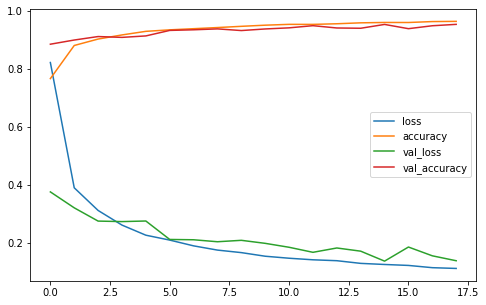

In [9]:
pd.DataFrame(history_mobilenet.history).plot(figsize=(8,5))
plt.show()

# Submit

In [10]:
import os
test_filenames = os.listdir("../input/classification-of-plants-of-southeast-asia/bali-26_test/bali-26_test")
test_df = pd.DataFrame({'id': test_filenames})
nb_samples = test_df.shape[0]
nb_samples
8000
from keras.preprocessing.image import ImageDataGenerator, load_img
test_gen = ImageDataGenerator()
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "../input/classification-of-plants-of-southeast-asia/bali-26_test/bali-26_test", 
    x_col='id',
    # y_col=None,
    class_mode=None,
    target_size=img_size,
    batch_size=batch_size,
    shuffle=False
)
predict = mobile_net.predict(test_generator)
test_df['category'] = np.argmax(predict, axis=-1)
name=train_ds.class_names
class_name=test_df['category'].tolist()
class_name=[name[i] for i in class_name]
test_df['category']=class_name
test_df.to_csv("submit.csv")

Found 4624 validated image filenames.


In [11]:
pred = pd.read_csv("./submit.csv")

In [12]:
pred.head()

Unnamed: 0        id    category
0           0  1269.jpg  waterguava
1           1  3863.jpg        sawo
2           2   623.jpg      banana
3           3  2193.jpg   sugarpalm
4           4  3750.jpg        taro

In [13]:
pred = pred.drop(axis=1, columns='Unnamed: 0')
pred.head()

id    category
0  1269.jpg  waterguava
1  3863.jpg        sawo
2   623.jpg      banana
3  2193.jpg   sugarpalm
4  3750.jpg        taro

In [14]:
pred.to_csv('./submit2.csv',index=False)

# Save weight


In [15]:
mobile_net.save_weights("model.h5")

In [16]:
import cv2

In [17]:
test_img = cv2.imread('../input/classification-of-plants-of-southeast-asia/bali-26_test/bali-26_test/155.jpg')

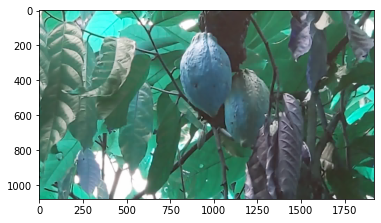

In [18]:
plt.imshow(test_img)

In [19]:
%cd /kaggle/working

/kaggle/working


In [20]:
from IPython.display import FileLink
FileLink(r'/kaggle/working/model.h5')

/kaggle/working/model.h5